# Notebook to infer reliable time horizon

To run this notebook you need to create and activate the following conda environment:

```
conda create --name score_eval numpy pandas matplotlib seaborn scipy ipython ipykernel -y
conda activate score_eval
pip install -e .
```


## Setup

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.utils_eval_score import (
    _get_ordinal_suffix,
    _plot_score_after_nth_abx_exposure,
    get_cutoff_value_sample_sizes,
    get_scores_n_abx_info,
)
from src.utils_t_horizon import (
    display_two_distributions,
    enrich_scores,
    plot_cutoff_date_distribution,
    plot_cutoff_host_id_distribution,
    sample_from_each_group,
    sample_unique_host_ids,
    transform_cutoff_scores,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

# avg. number of days per month
DAYS_PER_MONTH = 30.437

USER input: define the inferred model and linked datasets to evaluate here:

In [2]:
#### USER INPUT START
# name of the model
model_name = "saved_models_microbial_novel_alpha_div/id-56"
# which model version to evaluate: "best" or "last"
point_to_evaluate = "best"

# name of feature dataset used for model
ft_name = "ft_vat19_anomaly_v20240806_entero_genus"
# name of abx time-series used for model
abx_ts_name = "ts_vat19_abx_v20240806"

# limit evaluation to time range up to this many months (if None no limit is set
# and all scores are evaluated)
limit_months = 24.0

# whether to group samples prior to cutoff in analysis
group_samples = False

# how many samples prior and after cutoff to consider
min_samples = -3.0
max_samples = 24.0

# whether to filter noabx score samples by having at least 1 obs prior to cutoff
no_filter = True
#### USER INPUT END

## Prepare data

In [3]:
cutoff_scores_path = (
    f"../data/{model_name}/anomaly_detection/reliability_eval-val-noabx/"
)
evaluation_path = f"../data/{model_name}/anomaly_detection/reliability_evaluation/"

if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)

abx_scores_path = f"../data/{model_name}/anomaly_detection/scores_{point_to_evaluate}/"

### Get abx scores

In [4]:
noabx_train, noabx_val, abx_scores_flat, abx_df, abx_age_at_all = get_scores_n_abx_info(
    abx_scores_path, ft_name, limit_months, abx_ts_name, no_filter=no_filter
)

### Get noabx cutoff scores

In [5]:
# get noabx cutoff scores
c_scores_list = []
i_values = list(range(0, 1141, 30))

for i in i_values:
    c_scores = pd.read_csv(f"{cutoff_scores_path}val_noabx_ad_scores_{i}_coord-0.csv")

    # transform scores from wide to long format
    c_scores_t = transform_cutoff_scores(c_scores, DAYS_PER_MONTH)

    # filter scores
    c_scores_t = enrich_scores(c_scores_t)

    # append each cutoff date to each other
    c_scores_list.append(c_scores_t)

c_scores_all = pd.concat(c_scores_list, ignore_index=True)

if limit_months is not None:
    c_scores_all = c_scores_all[
        np.logical_and(
            c_scores_all["month5_bin"] <= limit_months,
            c_scores_all["cutoff_month"] < limit_months,
        )
    ]

c_scores_all.head()

,host_id,abx,use_obs_until_day,day,score,month_bin,month5_bin,cutoff_month,days_since_last_obs_before_cutoff,nb_obs_before_cutoff,days_since_cutoff,months_since_cutoff
0,E007944,False,0.0,52,1.399166,2,1.5,0,NaN,0,52.0,2.0
1,E007944,False,0.0,85,4.708012,3,3.0,0,NaN,0,85.0,3.0
2,E007944,False,0.0,113,15.150803,4,3.5,0,NaN,0,113.0,4.0
3,E007944,False,0.0,144,19.478883,5,4.5,0,NaN,0,144.0,5.0
4,E007944,False,0.0,174,23.024667,6,5.5,0,NaN,0,174.0,6.0


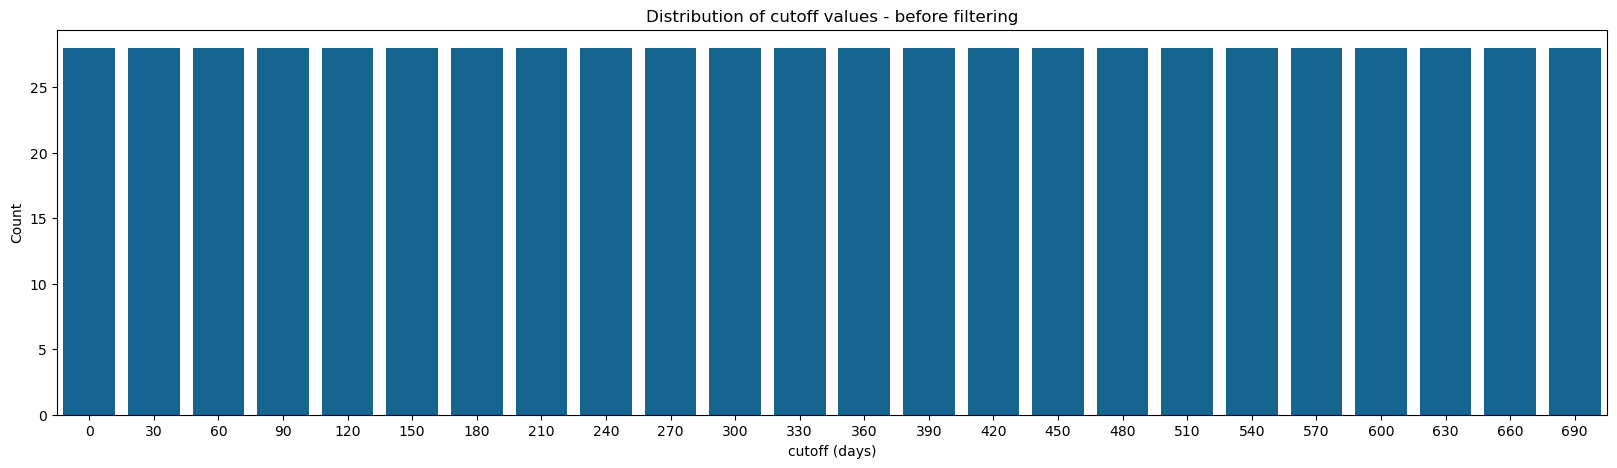

In [6]:
# plot before filtering:
plot_cutoff_date_distribution(c_scores_all, "- before filtering")

# filter scores
if not no_filter:
    # ! filter: at least one observation must be present before the cutoff
    c_scores_all_f = c_scores_all[c_scores_all["nb_obs_before_cutoff"] > 0].copy()
    # plot after filtering
    plot_cutoff_date_distribution(c_scores_all_f, "- after filtering")
else:
    c_scores_all_f = c_scores_all.copy()

In [7]:
# filter by months_since_cutoff to be in min_ max_samples range
c_scores_subset_f = c_scores_all_f.loc[
    np.logical_and(
        c_scores_all_f["months_since_cutoff"] >= min_samples,
        c_scores_all_f["months_since_cutoff"] <= max_samples,
    ),
    :,
]

c_scores_subset_f.shape

(4496, 12)

In [8]:
c_scores_subset_f.host_id.nunique()

28

## Visualize cutoffs - same "cutoff" subset as for 1st/2nd/3rd abx scores

In [9]:
# get all host's cutoffs to choose from
cutoff_host_mapping = c_scores_subset_f[["host_id", "cutoff_month"]].drop_duplicates()

for n in [1,2,3]:
    cutoff_values, sample_sizes = get_cutoff_value_sample_sizes(
        abx_scores_flat, abx_df, n, min_samples, max_samples, group_samples
    )

    # ! stratify to ensure unique hosts are used per subsampled cutoff
    # ! too few unique hosts present in validation set!
    # ! number of cutoffs for n=1: 37, number of unique hosts in val: 28
    cutoff_host_mapping_subset = sample_unique_host_ids(cutoff_host_mapping, sample_sizes, seed=42)
    # # subsample in cutoff_host_mapping by sample_sizes:
    # cutoff_host_mapping_subset = (
    #     cutoff_host_mapping.groupby("cutoff_month", group_keys=False)
    #     .apply(
    #         sample_from_each_group, sample_sizes=sample_sizes, seed=42, include_groups=True
    #     )
    #     .reset_index(drop=True)
    # )

    # VERIFY distributions: Now, cutoff_host_mapping_subset has the same
    # cutoff_month distribution as in cutoff_values
    display_two_distributions(
        orig_values = cutoff_values,
        sampled_values = cutoff_host_mapping_subset["cutoff_month"].values
    )

    # get only scores from cutoff_host_mapping_subset to plot
    sampled_subset_nth = pd.merge(
        c_scores_subset_f,
        cutoff_host_mapping_subset[["host_id", "cutoff_month"]],
        on=["host_id", "cutoff_month"],
        how="inner",
    )
    assert (
        sampled_subset_nth.host_id.nunique() == cutoff_host_mapping_subset.host_id.nunique()
    )

    _plot_score_after_nth_abx_exposure(
        sampled_subset_nth,
        x_axis="months_since_cutoff",
        y_axis="score",
        n=0,
        path_to_save=evaluation_path,
        flag=f"noabx_{n}matched_scores",
        tag=f"with {n}-{_get_ordinal_suffix(n)} abx matched cutoffs",
        min_samples=min_samples,
        max_samples=max_samples,
        grouped_samples=group_samples,
        uniqueness_var_ls=["use_obs_until_day"],
    )

0
1
2
3
4
5
6
7
8
9
10
11
12


ValueError: Not enough unique host_ids to sample for cutoff_month 12. Needed 4, but only 3 unique host_ids available.

## Visualize all cutoffs grouped by cutoff value

In [ ]:
all_cutoffs = c_scores_subset_f.use_obs_until_day.unique().tolist()


for cutoff in all_cutoffs:
    c_scores_subset_f_ss = c_scores_subset_f[
        c_scores_subset_f["use_obs_until_day"] == cutoff
    ].copy()
    print(cutoff)
    _plot_score_after_nth_abx_exposure(
        c_scores_subset_f_ss,
        x_axis="months_since_cutoff",
        y_axis="score",
        n=0,
        path_to_save=evaluation_path,
        flag=f"noabx_cutoff{int(cutoff)}_scores",
        tag=f"with cutoff={cutoff}",
        min_samples=min_samples,
        max_samples=max_samples,
        grouped_samples=group_samples,
    )

## Visualize all cutoffs pooled

In [ ]:
_plot_score_after_nth_abx_exposure(
    c_scores_subset_f,
    x_axis="months_since_cutoff",
    y_axis="score",
    n=0,
    path_to_save=evaluation_path,
    flag="noabx_cutoff_all_scores",
    tag="all cutoffs",
    min_samples=min_samples,
    max_samples=max_samples,
    grouped_samples=group_samples,
    uniqueness_var_ls=["use_obs_until_day"],
)
